In [1]:
from qiskit import IBMQ, QuantumCircuit, Aer, execute,transpile
from qiskit.quantum_info import Statevector, Operator
import math
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_qsphere, plot_distribution
from IPython.display import Markdown, HTML
import matplotlib.pyplot as plt

import os
from dotenv import load_dotenv

load_dotenv()

IBMQ_API_TOKEN = os.getenv('IBMQ_API_TOKEN')

IBMQ.save_account(IBMQ_API_TOKEN, overwrite=True)
IBMQ.load_account()



C:\Users\ekara\AppData\Local\Temp\ipykernel_29988\2386640195.py:15: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account(IBMQ_API_TOKEN, overwrite=True)
C:\Users\ekara\AppData\Local\Temp\ipykernel_29988\2386640195.py:15: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.save_account(IBMQ_API_TOKEN, overwrite=True)


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
def apply_n_hgates(qc, n):
    qc.h(range(n))
    return qc

def init_n_qubit_circuit(n):
    qc=QuantumCircuit(n,n)
    return qc

def grovers_algorithm(n, solutions, iterations):
    # Initialize the quantum circuit
    qc = init_n_qubit_circuit(n)
    qc.barrier(label="init")

    # Apply Hadamard gates to all qubits to create a superposition
    qc = apply_n_hgates(qc, n)
    
    # Apply the oracle and the diffuser multiple times
    for i in range(iterations):
        # Multi-target oracle
        oracle_circuit = multi_target_oracle(n, solutions)
        qc.barrier(label=f"O_{i+1}")
        qc = qc.compose(oracle_circuit)

        
        # Diffuser
        diffuser_circuit = diffuser(n)
        qc.barrier(label=f"D_{i+1}")
        qc = qc.compose(diffuser_circuit)
    qc.measure(range(n), range(n))
    return qc


def multi_target_oracle(n, solutions):
    oracle = QuantumCircuit(n)
    for solution in solutions:
        # Apply X gates to match the '0' in the solution
        for qubit in range(n):
            if solution[n-1-qubit] == '0':
                oracle.x(qubit)

        # Apply Controlled-Z
        oracle.h(0)  # Apply Hadamard to the target qubit
        oracle.mcx(list(range(1, n)), 0)  # Control on all higher bits, target is 0
        oracle.h(0)

        # Uncompute (cleanup X gates)
        for qubit in range(n):
            if solution[n-1-qubit] == '0':
                oracle.x(qubit)

    return oracle

def diffuser(n):
    qc = QuantumCircuit(n)
    
    # Apply Hadamard gates to all qubits
    qc.h(range(n))
    # Apply Pauli-X gates to all qubits
    qc.x(range(n))
    # Apply a multi-controlled-Z gate
    # First, apply Hadamard to the target qubit
    qc.h(n-1)
    # Apply the multi-controlled-X gate (acting as a multi-controlled-Z)
    # which controls are on all other qubits and target is the last qubit
    qc.mcx(list(range(n-1)), n-1)
    # Apply Hadamard again to the target qubit
    qc.h(n-1)
    # Apply Pauli-X gates to all qubits again
    qc.x(range(n))
    # Apply Hadamard gates to all qubits to finish
    qc.h(range(n))

    return qc

In [3]:
provider = IBMQ.get_provider('ibm-q')
backend = provider.get_backend('ibm_sherbrooke')  # Replace with your backend


In [4]:
n = 5  # Number of qubits
solutions = ['11111']
iterations = math.floor((math.pi/4)*(math.sqrt((2**n)/(len(solutions)))))

In [5]:
n = 5  # Number of qubits
solutions = ['11111']
iterations = math.floor((math.pi/4)*(math.sqrt((2**n)/(len(solutions)))))
grover_circuit = grovers_algorithm(n, solutions, iterations)

init ┌───┐ O_1 ┌───┐┌───┐┌───┐ D_1 ┌───┐┌───┐          ┌───┐┌───┐     »
q_0: ──░───┤ H ├──░──┤ H ├┤ X ├┤ H ├──░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────»
       ░   ├───┤  ░  └───┘└─┬─┘└───┘  ░  ├───┤├───┤       │  ├───┤├───┤     »
q_1: ──░───┤ H ├──░─────────■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────»
       ░   ├───┤  ░         │         ░  ├───┤├───┤       │  ├───┤├───┤     »
q_2: ──░───┤ H ├──░─────────■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────»
       ░   ├───┤  ░         │         ░  ├───┤├───┤       │  ├───┤├───┤     »
q_3: ──░───┤ H ├──░─────────■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────»
       ░   ├───┤  ░         │         ░  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐»
q_4: ──░───┤ H ├──░─────────■─────────░──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├»
       ░   └───┘  ░                   ░  └───┘└───┘└───┘└───┘└───┘└───┘└───┘»
c: 5/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«      O_2 ┌───┐┌───┐┌───┐ D_2 ┌───┐┌───┐          ┌───┐┌───┐      O_3 ┌───┐»
«q_0: ──░──┤ H ├┤ X ├┤ H ├──░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────░──┤ H ├»
«       ░  └───┘└─┬─┘└───┘  ░  ├───┤├───┤       │  ├───┤├───┤       ░  └───┘»
«q_1: ──░─────────■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────░───────»
«       ░         │         ░  ├───┤├───┤       │  ├───┤├───┤       ░       »
«q_2: ──░─────────■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────░───────»
«       ░         │         ░  ├───┤├───┤       │  ├───┤├───┤       ░       »
«q_3: ──░─────────■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────░───────»
«       ░         │         ░  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐  ░       »
«q_4: ──░─────────■─────────░──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├──░───────»
«       ░                   ░  └───┘└───┘└───┘└───┘└───┘└───┘└───┘  ░       »
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«     ┌───┐┌───┐ D_3 ┌───┐┌───┐          ┌───┐┌───┐      O_4 ┌───┐┌───┐┌───┐»
«q_0: ┤ X ├┤ H ├──░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────░──┤ H ├┤ X ├┤ H ├»
«     └─┬─┘└───┘  ░  ├───┤├───┤       │  ├───┤├───┤       ░  └───┘└─┬─┘└───┘»
«q_1: ──■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────░─────────■───────»
«       │         ░  ├───┤├───┤       │  ├───┤├───┤       ░         │       »
«q_2: ──■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────░─────────■───────»
«       │         ░  ├───┤├───┤       │  ├───┤├───┤       ░         │       »
«q_3: ──■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────░─────────■───────»
«       │         ░  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐  ░         │       »
«q_4: ──■─────────░──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├──░─────────■───────»
«                 ░  └───┘└───┘└───┘└───┘└───┘└───┘└───┘  ░                 »
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«      D_4 ┌───┐┌───┐          ┌───┐┌───┐     ┌─┐            
«q_0: ──░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────┤M├────────────
«       ░  ├───┤├───┤       │  ├───┤├───┤     └╥┘┌─┐         
«q_1: ──░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────╫─┤M├─────────
«       ░  ├───┤├───┤       │  ├───┤├───┤      ║ └╥┘┌─┐      
«q_2: ──░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────╫──╫─┤M├──────
«       ░  ├───┤├───┤       │  ├───┤├───┤      ║  ║ └╥┘┌─┐   
«q_3: ──░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────╫──╫──╫─┤M├───
«       ░  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ║  ║  ║ └╥┘┌─┐
«q_4: ──░──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫──╫──╫──╫─┤M├
«       ░  └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║  ║  ║  ║ └╥┘
«c: 5/═════════════════════════════════════════╩══╩══╩══╩══╩═
«                                              0  1  2  3  4

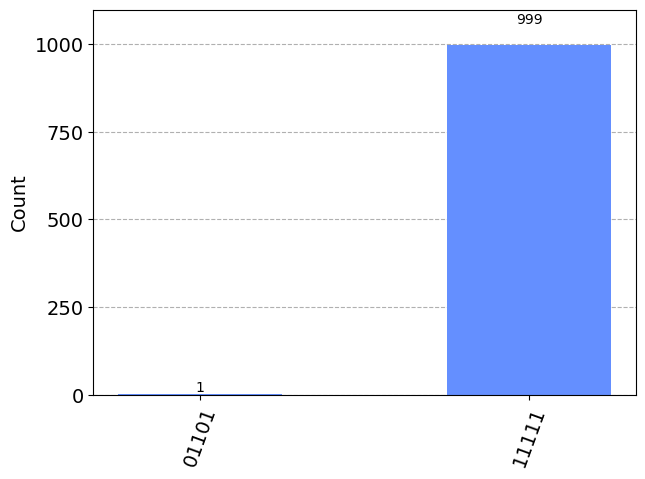

In [32]:
sim = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(grover_circuit, backend=sim, optimization_level=1)
display(compiled_circuit.draw())

# Execute the circuit
job = sim.run(compiled_circuit, shots=1000)
result = job.result()

# Obtain and plot the counts
counts = result.get_counts()
display(plot_histogram(counts))

In [6]:
transpiled_qc = transpile(grover_circuit, backend=backend, optimization_level=3)
print(transpiled_qc.count_ops())


OrderedDict([('rz', 2262), ('sx', 1413), ('ecr', 505), ('x', 75), ('barrier', 10), ('measure', 5)])


In [ ]:
job = backend.run(transpiled_qc, shots=1000)
result = job.result()  # Fetch results
counts = result.get_counts(grover_circuit)  # Get the count of each measurement result
display(plot_histogram(counts))